# 01 — Data Loading & Full EDA

**Purpose:** Industry-standard exploratory data analysis for the Financial Transaction Risk & Fraud Early-Warning System.

**Scope:**
- Load all 5 sources (transactions, cards, users, mcc_codes, fraud labels)
- Schema audit: dtypes, null %, cardinality, range/sample
- Data quality checks: duplicates, temporal range, amounts
- Gold table (sample) and join coverage
- Statistics: numeric summaries, categorical distributions
- Visualizations: time series, distributions, bar charts, heatmaps

**Note:** Transactions are sampled (e.g. 500k rows) for fast EDA; full dataset ~13.3M rows.

## 1. Setup & project root

In [30]:
import sys
from pathlib import Path

# Project root (parent of notebooks/)
PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.ingestion import load_transactions, load_cards, load_users, load_mcc_codes, load_fraud_labels
from src.ingestion.gold_table import build_gold_table
from src.eda import schema_audit_df, data_quality_checks, numeric_summary, categorical_summary
try:
    from src.eda.plot_style import apply_style, get_colors, PALETTE, CATEGORY_PALETTE
    apply_style(style="whitegrid", context="notebook", font_scale=1.15, figsize_default=(10, 5), dpi=120)
except ImportError:
    import seaborn as sns
    sns.set_theme(style="whitegrid", font_scale=1.1)
    PALETTE = {"primary": "#1e3a5f", "secondary": "#2d6a6e", "accent": "#c75c41", "neutral": "#6b7280", "white": "#ffffff"}
    CATEGORY_PALETTE = [PALETTE["primary"], PALETTE["secondary"], PALETTE["accent"], PALETTE["neutral"]]

%matplotlib inline

## 2. Load all 5 sources

In [29]:
# Sample size for transactions (use None for full ~13.3M; 500_000 is fast for EDA)
TXN_SAMPLE = 500_000

txn = load_transactions(nrows=TXN_SAMPLE)
cards = load_cards()
users = load_users()
mcc_codes = load_mcc_codes()
labels = load_fraud_labels()

print("Transactions (sample):", txn.shape)
print("Cards:", cards.shape)
print("Users:", users.shape)
print("MCC codes:", len(mcc_codes))
print("Fraud labels:", len(labels), "| Fraud (Yes):", sum(labels.values()))

Transactions (sample): (500000, 12)
Cards: (6146, 13)
Users: (2000, 14)
MCC codes: 109
Fraud labels: 8914963 | Fraud (Yes): 13332


## 3. Schema audit (all tables)

In [31]:
audit_txn = schema_audit_df(txn, "transactions")
display(audit_txn)

,column,dtype,null_count,null_pct,cardinality,range_or_sample
0,id,int64,0,0.00,500000,"[7475327.00, 8073848.00]"
1,date,datetime64[us],0,0.00,168729,"[2010-01-01 00:01:00, 2010-05-31 07:21:00]"
2,client_id,int64,0,0.00,1112,"[0.00, 1998.00]"
3,card_id,int64,0,0.00,2643,"[0.00, 5990.00]"
4,amount,str,0,0.00,28112,"['$-77.00', '$14.57', '$80.00']"
5,use_chip,str,0,0.00,2,"['Swipe Transaction', 'Swipe Transaction', 'Sw..."
6,merchant_id,int64,0,0.00,19040,"[9.00, 100340.00]"
7,merchant_city,str,0,0.00,5583,"['Beulah', 'Bettendorf', 'Vista']"
8,merchant_state,str,54832,10.97,102,"['ND', 'IA', 'CA']"
9,zip,float64,57535,11.51,10437,"[1022.00, 99840.00]"


In [32]:
audit_cards = schema_audit_df(cards, "cards")
display(audit_cards)

,column,dtype,null_count,null_pct,cardinality,range_or_sample
0,id,int64,0,0.0,6146,"[0.00, 6145.00]"
1,client_id,int64,0,0.0,2000,"[0.00, 1999.00]"
2,card_brand,str,0,0.0,4,"['Visa', 'Visa', 'Visa']"
3,card_type,str,0,0.0,3,"['Debit', 'Debit', 'Debit']"
4,card_number,int64,0,0.0,6146,"[300105541992311.00, 6997197066610978.00]"
5,expires,str,0,0.0,259,"['12/2022', '12/2020', '02/2024']"
6,cvv,int64,0,0.0,998,"[0.00, 999.00]"
7,has_chip,str,0,0.0,2,"['YES', 'YES', 'YES']"
8,num_cards_issued,int64,0,0.0,3,"[1.00, 3.00]"
9,credit_limit,str,0,0.0,3654,"['$24295', '$21968', '$46414']"


In [33]:
audit_users = schema_audit_df(users, "users")
display(audit_users)

,column,dtype,null_count,null_pct,cardinality,range_or_sample
0,id,int64,0,0.0,2000,"[0.00, 1999.00]"
1,current_age,int64,0,0.0,80,"[18.00, 101.00]"
2,retirement_age,int64,0,0.0,29,"[50.00, 79.00]"
3,birth_year,int64,0,0.0,80,"[1918.00, 2002.00]"
4,birth_month,int64,0,0.0,12,"[1.00, 12.00]"
5,gender,str,0,0.0,2,"['Female', 'Female', 'Female']"
6,address,str,0,0.0,1999,"['462 Rose Lane', '3606 Federal Boulevard', '7..."
7,latitude,float64,0,0.0,989,"[20.88, 61.20]"
8,longitude,float64,0,0.0,1224,"[-159.41, -68.67]"
9,per_capita_income,str,0,0.0,1754,"['$29278', '$37891', '$22681']"


## 4. Data quality checks

In [34]:
# Transactions: duplicate IDs, dates, amounts
txn_checks = data_quality_checks(txn, id_col="id", date_col="date", amount_col="amount")
for k, v in txn_checks.items():
    print(f"  {k}: {v}")

  duplicate_ids: 0
  unique_id_ratio: 1.0
  null_dates: 0
  future_dates: 0
  date_min: 2010-01-01 00:01:00
  date_max: 2010-05-31 07:21:00
  null_amounts: 0
  negative_amounts: 25890
  zero_amounts: 420


In [35]:
# Cards: duplicate IDs, referential integrity (client_id in users)
card_checks = data_quality_checks(cards, id_col="id")
print("Cards:", card_checks)
cards_with_user = cards["client_id"].isin(users["id"])
print("Cards with valid client_id:", cards_with_user.sum(), "/", len(cards))

Cards: {'duplicate_ids': 0, 'unique_id_ratio': 1.0}
Cards with valid client_id: 6146 / 6146


In [36]:
# Users: duplicate IDs
user_checks = data_quality_checks(users, id_col="id")
print("Users:", user_checks)

Users: {'duplicate_ids': 0, 'unique_id_ratio': 1.0}


## 5. Gold table (sample) & label coverage

In [37]:
gold = build_gold_table(nrows=TXN_SAMPLE, save_path=None)
# Parse amount for EDA (numeric summaries and plots)
gold["amount_num"] = gold["amount"].astype(str).str.replace(r"[$,\s]", "", regex=True).astype(float)
print("Gold table shape:", gold.shape)
print("Columns:", gold.columns.tolist()[:20], "...")
labeled = gold["has_label"].sum()
fraud_count = gold.loc[gold["has_label"], "is_fraud"].sum()
print("Labeled transactions:", labeled, f"({100*labeled/len(gold):.1f}%)")
print("Fraud (among labeled):", fraud_count, f"({100*fraud_count/max(1,labeled):.2f}%)")

Gold table shape: (500000, 50)
Columns: ['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors', 'hour_of_day', 'day_of_week', 'is_weekend', 'month', 'is_night', 'id_card', 'client_id_card', 'card_brand'] ...
Labeled transactions: 335017 (67.0%)
Fraud (among labeled): 1135.0 (0.34%)


## 6. Numeric & categorical summaries

In [38]:
# Numeric summary (exclude IDs)
num_cols = [c for c in gold.select_dtypes(include=[np.number]).columns
             if c not in ("id", "card_id", "client_id", "merchant_id", "year")]
numeric_summary(gold[num_cols]).head(20)

,count,mean,std,min,25%,50%,75%,max
zip,442465.0,5.159925e+04,2.936106e+04,1.022000e+03,2.871500e+04,4.803200e+04,7.790100e+04,9.984000e+04
mcc,500000.0,5.563407e+03,8.696508e+02,1.711000e+03,5.300000e+03,5.499000e+03,5.812000e+03,9.402000e+03
hour_of_day,500000.0,1.241931e+01,5.100818e+00,0.000000e+00,9.000000e+00,1.200000e+01,1.600000e+01,2.300000e+01
day_of_week,500000.0,3.005072e+00,2.015747e+00,0.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00
is_weekend,500000.0,2.893800e-01,4.534751e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
month,500000.0,3.015790e+00,1.418154e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
is_night,500000.0,4.446600e-02,2.061283e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
id_card,500000.0,3.371120e+03,1.701494e+03,0.000000e+00,2.216000e+03,3.426000e+03,4.737000e+03,5.990000e+03
client_id_card,500000.0,1.033050e+03,5.829788e+02,0.000000e+00,5.170000e+02,1.077000e+03,1.538000e+03,1.998000e+03
card_number,500000.0,4.793674e+15,1.361109e+15,3.001055e+14,4.463425e+15,5.124869e+15,5.576035e+15,6.994218e+15


In [39]:
# Categorical: card_brand, card_type, use_chip
for col in ["card_brand", "card_type", "use_chip"]:
    if col in gold.columns:
        print(col)
        display(categorical_summary(gold, [col])[col])

card_brand


,count,pct
card_brand,,
Mastercard,267907,53.58
Visa,184047,36.81
Amex,35311,7.06
Discover,12735,2.55


card_type


,count,pct
card_type,,
Debit,307612,61.52
Credit,158017,31.60
Debit (Prepaid),34371,6.87


use_chip


,count,pct
use_chip,,
Swipe Transaction,445168,89.03
Online Transaction,54832,10.97


## 7. Visualizations

### 7.1 Transaction volume over time

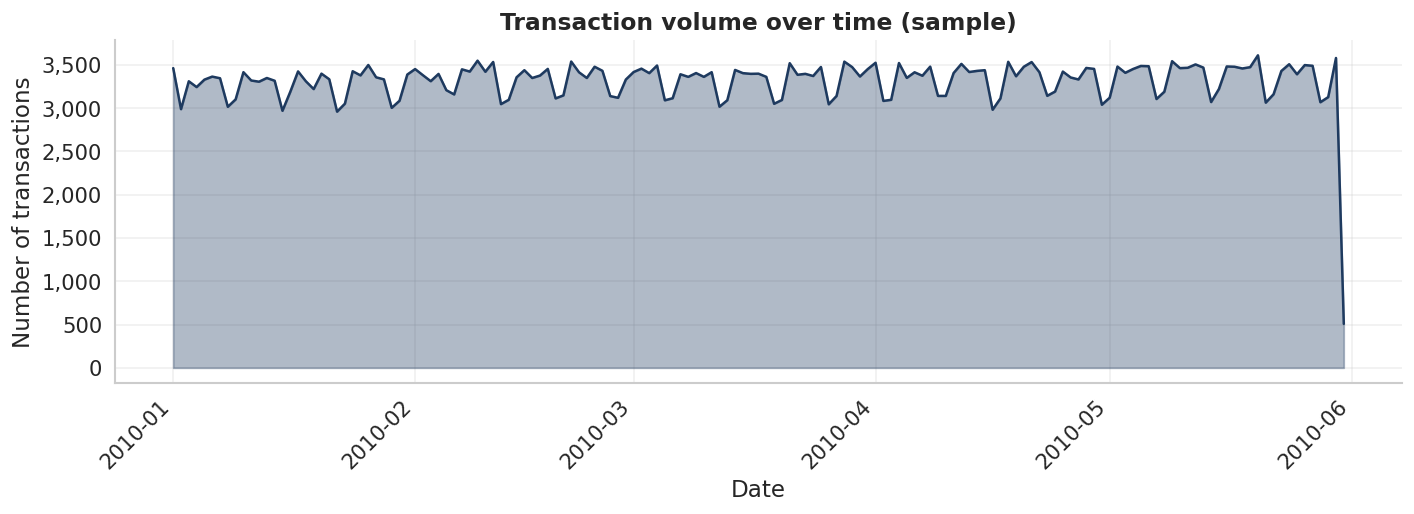

In [40]:
txn["date_only"] = pd.to_datetime(txn["date"]).dt.date
daily = txn.groupby("date_only").size().reset_index(name="count")
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.fill_between(daily["date_only"], daily["count"], alpha=0.35, color=PALETTE["primary"])
ax.plot(daily["date_only"], daily["count"], color=PALETTE["primary"], linewidth=1.5)
ax.set_title("Transaction volume over time (sample)", fontsize=14, fontweight="600")
ax.set_xlabel("Date")
ax.set_ylabel("Number of transactions")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
plt.xticks(rotation=45, ha="right")
sns.despine(ax=ax)
plt.tight_layout()
plt.show()

### 7.2 Amount distribution

### 7.3 Label coverage (labeled vs unlabeled)

Only a subset of transactions have fraud labels; unlabeled must not be treated as non-fraud.

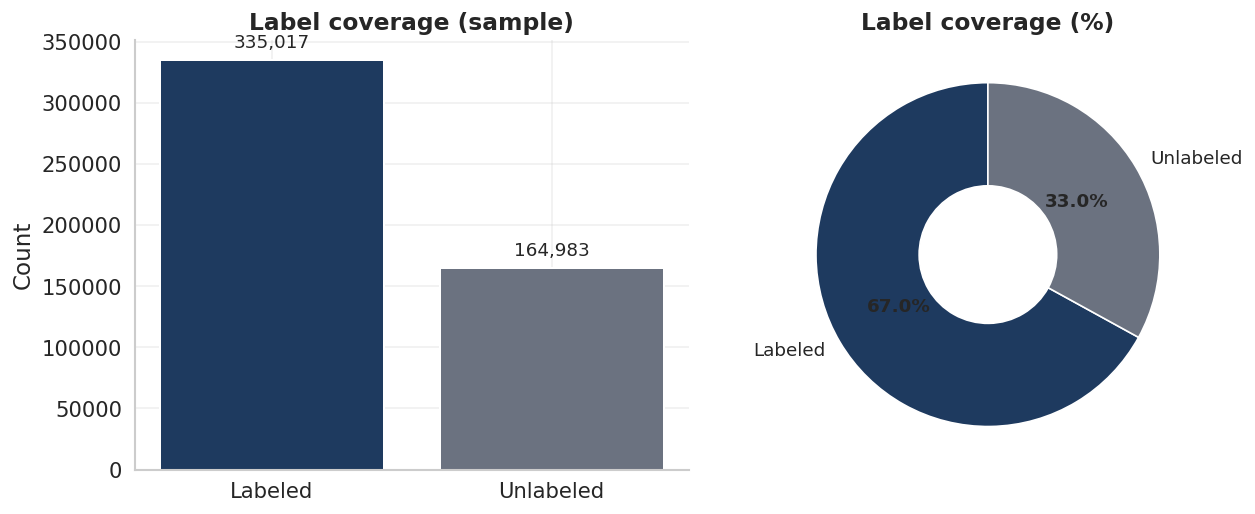

In [41]:
label_coverage = gold["has_label"].value_counts().rename({True: "Labeled", False: "Unlabeled"})
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
colors_lc = [PALETTE["primary"], PALETTE["neutral"]]
bars = axes[0].bar(label_coverage.index.astype(str), label_coverage.values, color=colors_lc, edgecolor="white", linewidth=1.2)
axes[0].set_title("Label coverage (sample)", fontsize=14, fontweight="600")
axes[0].set_ylabel("Count")
for b in bars:
    axes[0].text(b.get_x() + b.get_width()/2, b.get_height() + 0.02*axes[0].get_ylim()[1], f"{int(b.get_height()):,}", ha="center", va="bottom", fontsize=11)
wedges, texts, autotexts = axes[1].pie(label_coverage.values, labels=label_coverage.index, autopct="%1.1f%%", colors=colors_lc, startangle=90, wedgeprops=dict(width=0.6), textprops=dict(fontsize=11))
for t in autotexts:
    t.set_fontweight("600")
axes[1].set_title("Label coverage (%)", fontsize=14, fontweight="600")
sns.despine(ax=axes[0])
plt.tight_layout()
plt.show()

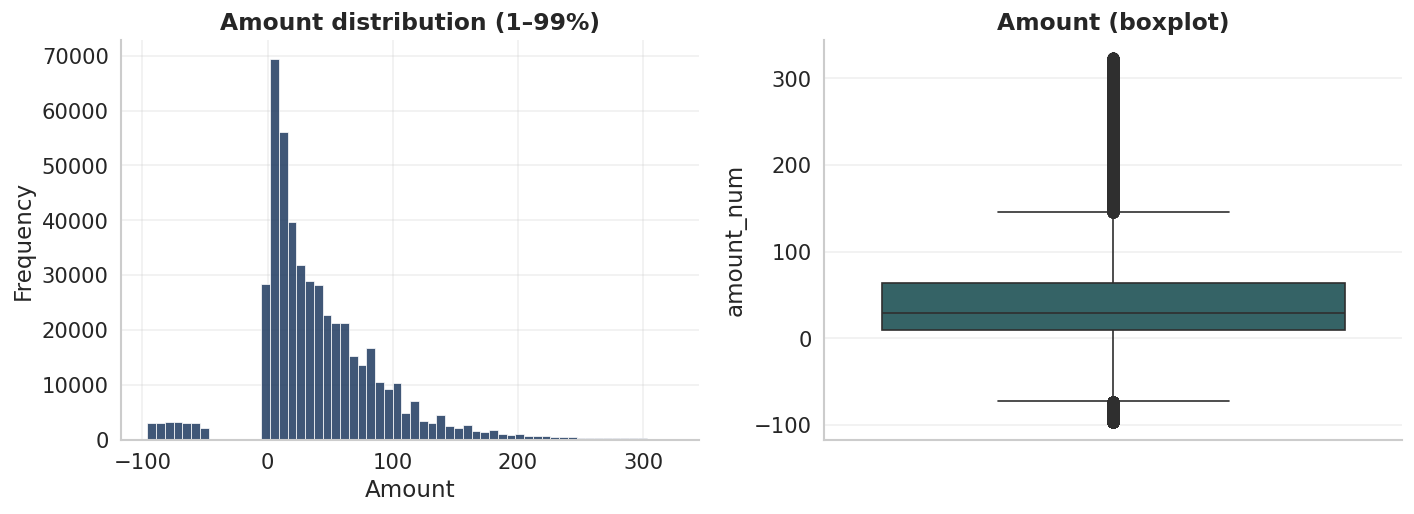

In [42]:
amount_series = gold["amount_num"].dropna()
amount_series = amount_series[(amount_series >= amount_series.quantile(0.01)) & (amount_series <= amount_series.quantile(0.99))]
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
axes[0].hist(amount_series, bins=60, color=PALETTE["primary"], edgecolor="white", alpha=0.85, linewidth=0.5)
axes[0].set_title("Amount distribution (1–99%)", fontsize=14, fontweight="600")
axes[0].set_xlabel("Amount")
axes[0].set_ylabel("Frequency")
sns.boxplot(y=amount_series, ax=axes[1], color=PALETTE["secondary"])
axes[1].set_title("Amount (boxplot)", fontsize=14, fontweight="600")
sns.despine(ax=axes[0])
sns.despine(ax=axes[1])
plt.tight_layout()
plt.show()

### 7.4 Fraud / class distribution (labeled only)

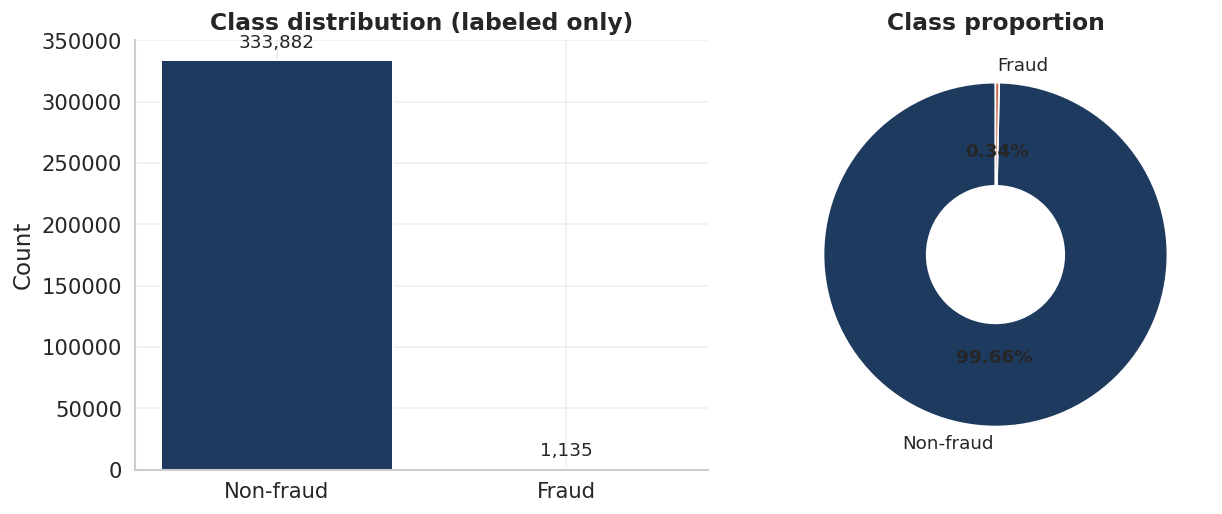

In [43]:
labeled_only = gold[gold["has_label"]]
fraud_counts = labeled_only["is_fraud"].value_counts().rename({0: "Non-fraud", 1: "Fraud"})
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
colors_f = [PALETTE["primary"], PALETTE["accent"]]
bars = axes[0].bar(fraud_counts.index.astype(str), fraud_counts.values, color=colors_f, edgecolor="white", linewidth=1.2)
axes[0].set_title("Class distribution (labeled only)", fontsize=14, fontweight="600")
axes[0].set_ylabel("Count")
for b in bars:
    axes[0].text(b.get_x() + b.get_width()/2, b.get_height() + 0.02*axes[0].get_ylim()[1], f"{int(b.get_height()):,}", ha="center", va="bottom", fontsize=11)
wedges, texts, autotexts = axes[1].pie(fraud_counts.values, labels=fraud_counts.index, autopct="%1.2f%%", colors=colors_f, startangle=90, wedgeprops=dict(width=0.6), textprops=dict(fontsize=11))
for t in autotexts:
    t.set_fontweight("600")
axes[1].set_title("Class proportion", fontsize=14, fontweight="600")
sns.despine(ax=axes[0])
plt.tight_layout()
plt.show()

### 7.5 Fraud rate by year (labeled subset)

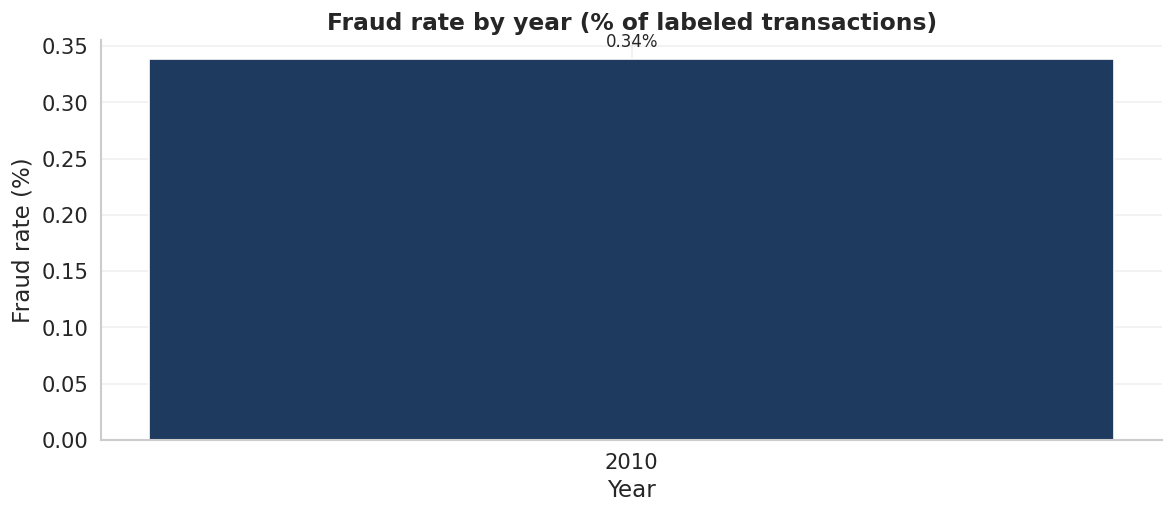

In [44]:
gold["year"] = pd.to_datetime(gold["date"]).dt.year
by_year = gold[gold["has_label"]].groupby("year").agg(
    total=("is_fraud", "count"),
    fraud=("is_fraud", "sum"),
).assign(fraud_rate=lambda x: 100 * x["fraud"] / x["total"])
fig, ax = plt.subplots(figsize=(10, 4.5))
bars = ax.bar(by_year.index.astype(str), by_year["fraud_rate"], color=PALETTE["primary"], edgecolor="white", linewidth=1)
ax.set_title("Fraud rate by year (% of labeled transactions)", fontsize=14, fontweight="600")
ax.set_xlabel("Year")
ax.set_ylabel("Fraud rate (%)")
for b in bars:
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02*ax.get_ylim()[1], f"{b.get_height():.2f}%", ha="center", va="bottom", fontsize=10)
sns.despine(ax=ax)
plt.tight_layout()
plt.show()

### 7.6 Card brand & card type

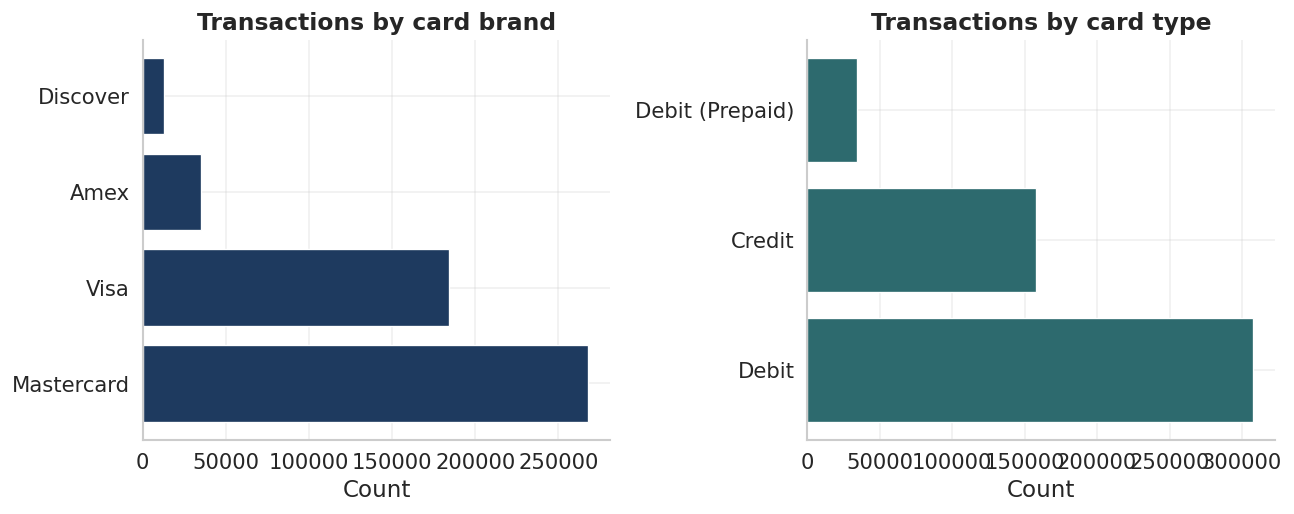

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
brand_counts = gold["card_brand"].value_counts()
type_counts = gold["card_type"].value_counts()
axes[0].barh(brand_counts.index, brand_counts.values, color=PALETTE["primary"], edgecolor="white", linewidth=0.8)
axes[0].set_title("Transactions by card brand", fontsize=14, fontweight="600")
axes[0].set_xlabel("Count")
axes[1].barh(type_counts.index, type_counts.values, color=PALETTE["secondary"], edgecolor="white", linewidth=0.8)
axes[1].set_title("Transactions by card type", fontsize=14, fontweight="600")
axes[1].set_xlabel("Count")
sns.despine(ax=axes[0])
sns.despine(ax=axes[1])
plt.tight_layout()
plt.show()

### 7.7 Top MCC (merchant category) by transaction count

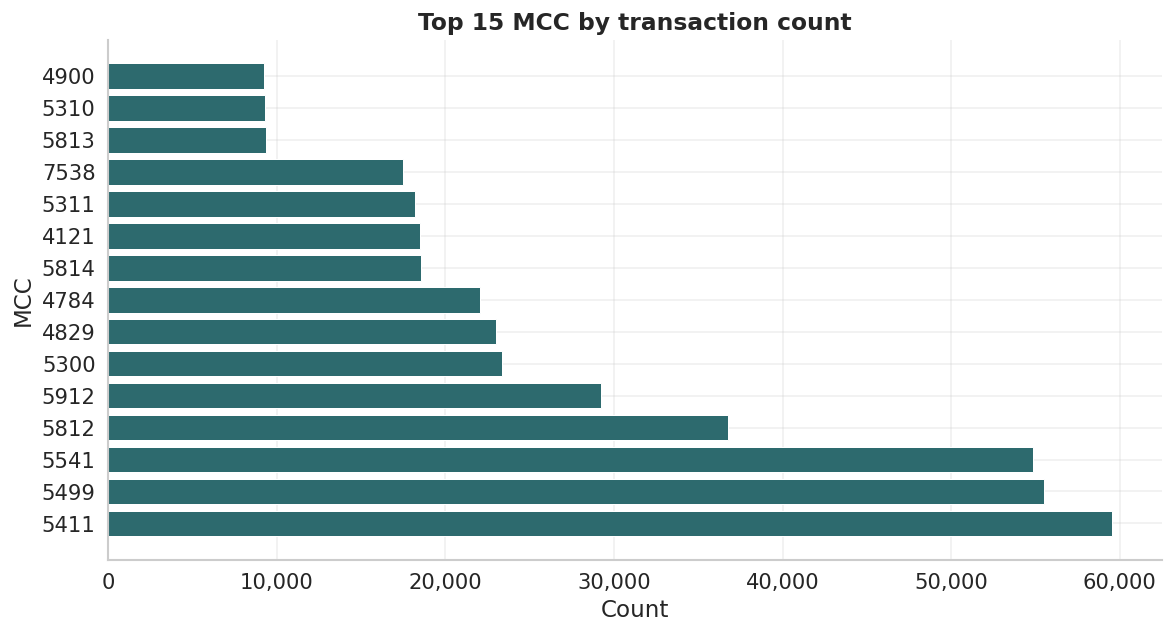

In [46]:
mcc_counts = gold["mcc_str"].value_counts().head(15)
fig, ax = plt.subplots(figsize=(10, 5.5))
ax.barh(mcc_counts.index.astype(str), mcc_counts.values, color=PALETTE["secondary"], edgecolor="white", linewidth=0.6)
ax.set_title("Top 15 MCC by transaction count", fontsize=14, fontweight="600")
ax.set_xlabel("Count")
ax.set_ylabel("MCC")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
sns.despine(ax=ax)
plt.tight_layout()
plt.show()

### 7.8 Missing values (share per column)

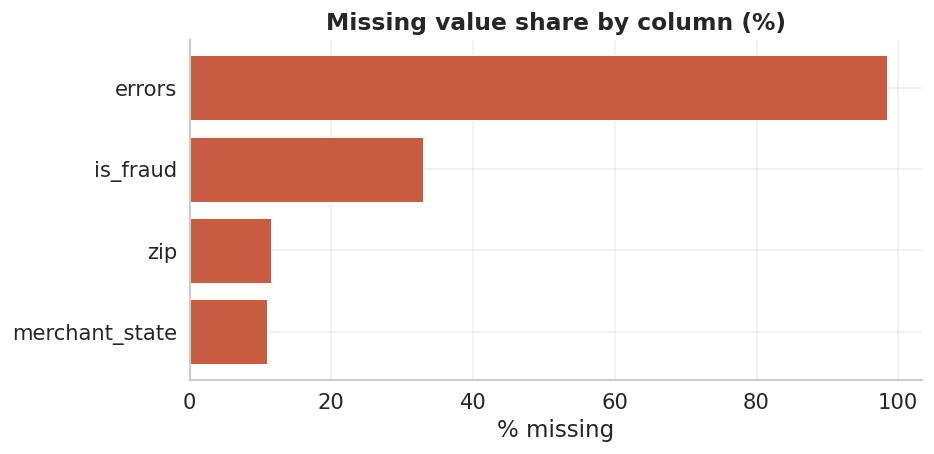

In [47]:
missing = (gold.isna().sum() / len(gold) * 100).sort_values(ascending=True)
missing = missing[missing > 0]
if len(missing) > 0:
    fig, ax = plt.subplots(figsize=(8, max(4, len(missing) * 0.35)))
    ax.barh(missing.index, missing.values, color=PALETTE["accent"], edgecolor="white", linewidth=0.6)
    ax.set_title("Missing value share by column (%)", fontsize=14, fontweight="600")
    ax.set_xlabel("% missing")
    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values in gold sample.")

### 7.9 Correlation heatmap (numeric features)

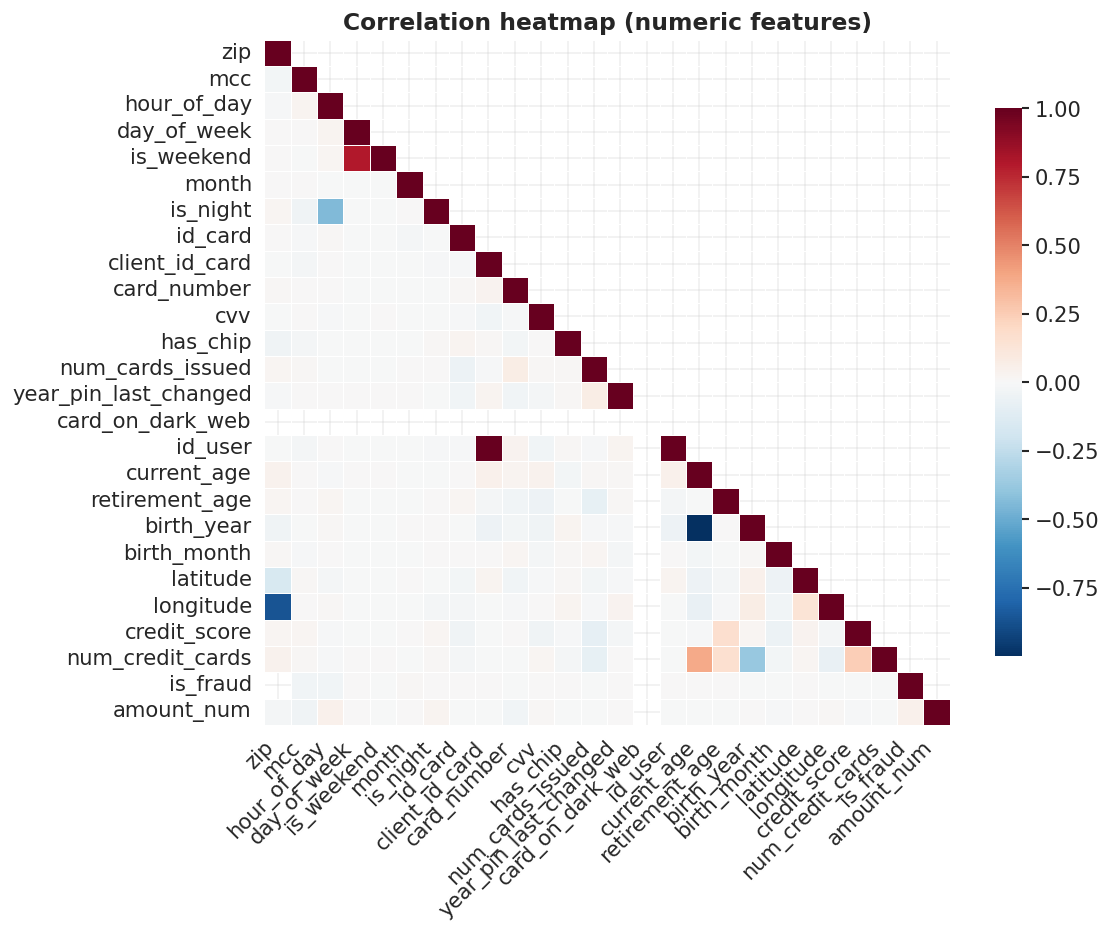

In [48]:
num_cols = gold.select_dtypes(include=[np.number]).columns
exclude = {"id", "card_id", "client_id", "merchant_id", "year"}
num_cols = [c for c in num_cols if c not in exclude]
corr = gold[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=False, cmap="RdBu_r", center=0, ax=ax, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
ax.set_title("Correlation heatmap (numeric features)", fontsize=14, fontweight="600")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### 7.10 Hour-of-day and day-of-week (transaction volume)

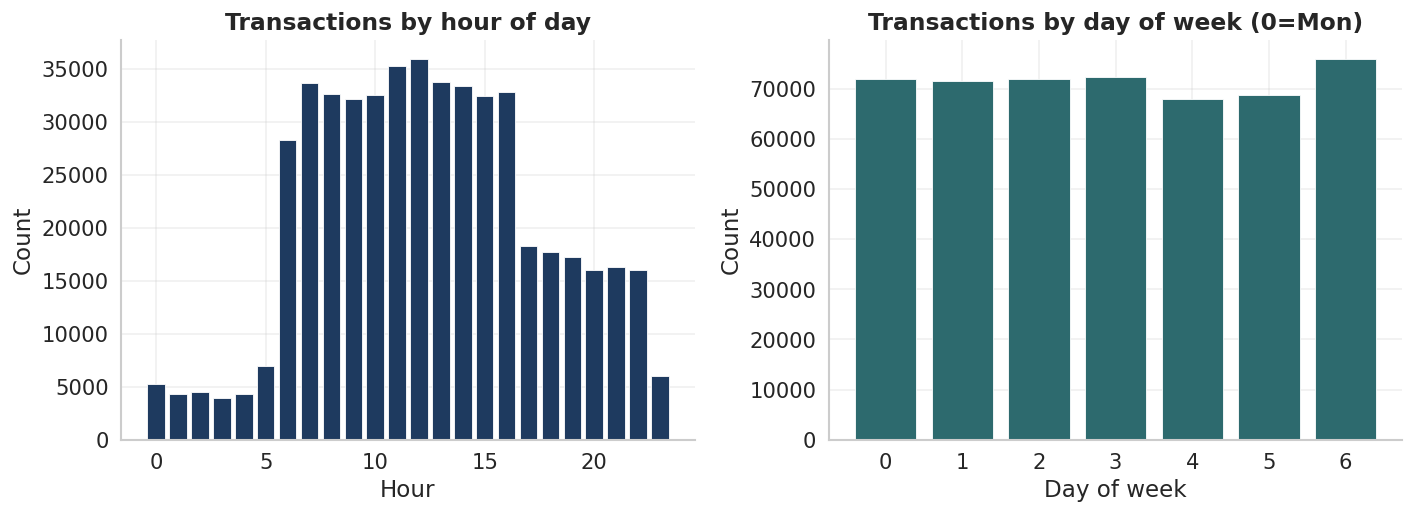

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
hour_counts = gold["hour_of_day"].value_counts().sort_index()
dow_counts = gold["day_of_week"].value_counts().sort_index()
axes[0].bar(hour_counts.index, hour_counts.values, color=PALETTE["primary"], edgecolor="white", linewidth=0.5)
axes[0].set_title("Transactions by hour of day", fontsize=14, fontweight="600")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Count")
axes[1].bar(dow_counts.index, dow_counts.values, color=PALETTE["secondary"], edgecolor="white", linewidth=0.5)
axes[1].set_title("Transactions by day of week (0=Mon)", fontsize=14, fontweight="600")
axes[1].set_xlabel("Day of week")
axes[1].set_ylabel("Count")
sns.despine(ax=axes[0])
sns.despine(ax=axes[1])
plt.tight_layout()
plt.show()

## 8. Summary statistics (transactions)

In [50]:
txn.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,500000.0,NaN,NaN,NaN,7774317.65825,7475327.0,7624628.5,7774099.5,7923876.25,8073848.0,172786.228046
date,500000,NaN,NaN,NaN,2010-03-17 12:26:05.383920,2010-01-01 00:01:00,2010-02-08 06:59:45,2010-03-17 13:57:30,2010-04-24 02:15:15,2010-05-31 07:21:00,NaN
client_id,500000.0,NaN,NaN,NaN,1033.050268,0.0,517.0,1077.0,1538.0,1998.0,582.978846
card_id,500000.0,NaN,NaN,NaN,3371.119554,0.0,2216.0,3426.0,4737.0,5990.0,1701.493664
amount,500000,28112,$80.00,5280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
use_chip,500000,2,Swipe Transaction,445168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
merchant_id,500000.0,NaN,NaN,NaN,47738.793156,9.0,25887.0,46284.0,67274.0,100340.0,25746.596007
merchant_city,500000,5583,ONLINE,54832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
merchant_state,445168,102,CA,53985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zip,442465.0,NaN,NaN,NaN,51599.253498,1022.0,28715.0,48032.0,77901.0,99840.0,29361.062898
